In [1]:
#Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Read the CSV file
df = pd.read_csv("Wrangled_df.csv",index_col = "Movie ID")
df.head()

,Name,Year,Score,Genre,Budget,Revenue,Language,Profit
Movie ID,,,,,,,,
0,the passion of the christ,2004,74.0,Drama,25000000.0,6.223136e+08,English,5.973136e+08
1,john wick: chapter 2,2017,73.0,"Action, Thriller, Crime",40000000.0,1.715399e+08,English,1.315399e+08
2,john wick: chapter 3 - parabellum,2019,74.0,"Action, Thriller, Crime",55000000.0,3.267097e+08,English,2.717097e+08
3,a bronx tale,1994,78.0,"Drama, Crime",10000000.0,1.728790e+07,English,7.287898e+06
4,avatar,2009,76.0,"Action, Adventure, Fantasy, Science Fiction",237000000.0,2.923706e+09,English,2.686706e+09


# Expanding Genre into multiple binary columns

In [3]:
# Initialize an empty set to store all unique genres
unique_genres = set()

# Iterate over the DataFrame rows
for index, row in df.iterrows():
    # Split the 'Genre' column by commas and add each genre to the set
    movie_genres = [genre.strip() for genre in row['Genre'].split(',')]
    unique_genres.update(movie_genres)

# Convert the set of unique genres to a list
unique_genres = list(unique_genres)

# Iterate over the DataFrame rows again to create genre columns
for index, row in df.iterrows():
    # Split the 'Genre' column by commas and create a dictionary to store genre values
    movie_genres = {genre: 1 if genre.strip() in row['Genre'] else 0 for genre in unique_genres}
    
    # Update the DataFrame row with genre values
    for genre, value in movie_genres.items():
        df.at[index, genre] = value

# Print the updated DataFrame
df.head(15)

,Name,Year,Score,Genre,Budget,Revenue,Language,Profit,Action,Animation,...,History,Drama,Horror,TV Movie,Thriller,Science Fiction,Family,Fantasy,Western,Romance
Movie ID,,,,,,,,,,,,,,,,,,,,,
0,the passion of the christ,2004,74.0,Drama,25000000.0,6.223136e+08,English,5.973136e+08,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,john wick: chapter 2,2017,73.0,"Action, Thriller, Crime",40000000.0,1.715399e+08,English,1.315399e+08,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,john wick: chapter 3 - parabellum,2019,74.0,"Action, Thriller, Crime",55000000.0,3.267097e+08,English,2.717097e+08,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,a bronx tale,1994,78.0,"Drama, Crime",10000000.0,1.728790e+07,English,7.287898e+06,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,avatar,2009,76.0,"Action, Adventure, Fantasy, Science Fiction",237000000.0,2.923706e+09,English,2.686706e+09,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
5,john wick,2014,74.0,"Action, Thriller",30000000.0,7.595880e+07,English,4.595880e+07,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,super mario bros.,1993,43.0,"Action, Adventure, Comedy, Family, Science Fic...",42000000.0,2.084491e+07,English,-2.115509e+07,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
7,shazam!,2019,70.0,"Action, Comedy, Fantasy",85000000.0,3.635639e+08,English,2.785639e+08,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8,avengers: infinity war,2018,83.0,"Adventure, Action, Science Fiction",300000000.0,2.048360e+09,English,1.748360e+09,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


# Making a new Data Frame 

In [46]:
# Initialize lists to store data for pie chart
size = []
label = []
Genre = []
profit = []
budget = []
year = []
score =[]

# Iterate over the DataFrame rows
for index, row in df.iterrows():
    # Iterate over each genre column and check if it's 1
    for genre in unique_genres:
        if row[genre] == 1:
            # Append relevant data to lists
            label.append(row['Name'])
            size.append(row['Revenue'])  
            profit.append(row['Profit'])
            budget.append(row['Budget'])
            year.append(row['Year'])
            score.append(row['Score'])
            Genre.append(genre)
            
# Create a DataFrame from the lists
data = {'Name': label, 'Genre': Genre, 'Revenue': size, 'Profit':profit, 'Budget':budget, 'Year':year, 'Socre':score}
df_genre = pd.DataFrame(data)
df_genre.head ()

,Name,Genre,Revenue,Profit,Budget,Year,Socre
0,the passion of the christ,Drama,622313635.0,597313635.0,25000000.0,2004,74.0
1,john wick: chapter 2,Action,171539887.0,131539887.0,40000000.0,2017,73.0
2,john wick: chapter 2,Crime,171539887.0,131539887.0,40000000.0,2017,73.0
3,john wick: chapter 2,Thriller,171539887.0,131539887.0,40000000.0,2017,73.0
4,john wick: chapter 3 - parabellum,Action,326709727.0,271709727.0,55000000.0,2019,74.0


# Total count of data points in each Genres

In [5]:
genre_counts = df_genre.groupby('Genre')['Revenue'].count()
genre_counts

Genre
Action             1436
Adventure          1015
Animation           654
Comedy             1666
Crime               704
Documentary          96
Drama              1823
Family              886
Fantasy             655
History             207
Horror              813
Music               158
Mystery             491
Romance             712
Science Fiction     706
TV Movie            133
Thriller           1450
War                 129
Western              51
Name: Revenue, dtype: int64

# Plot the data to see data distribution

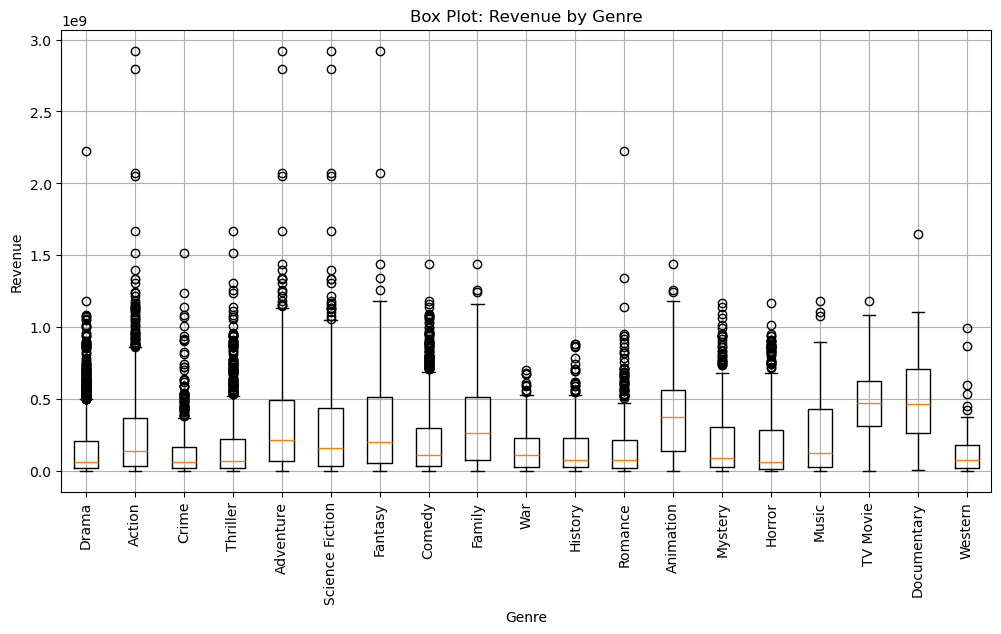

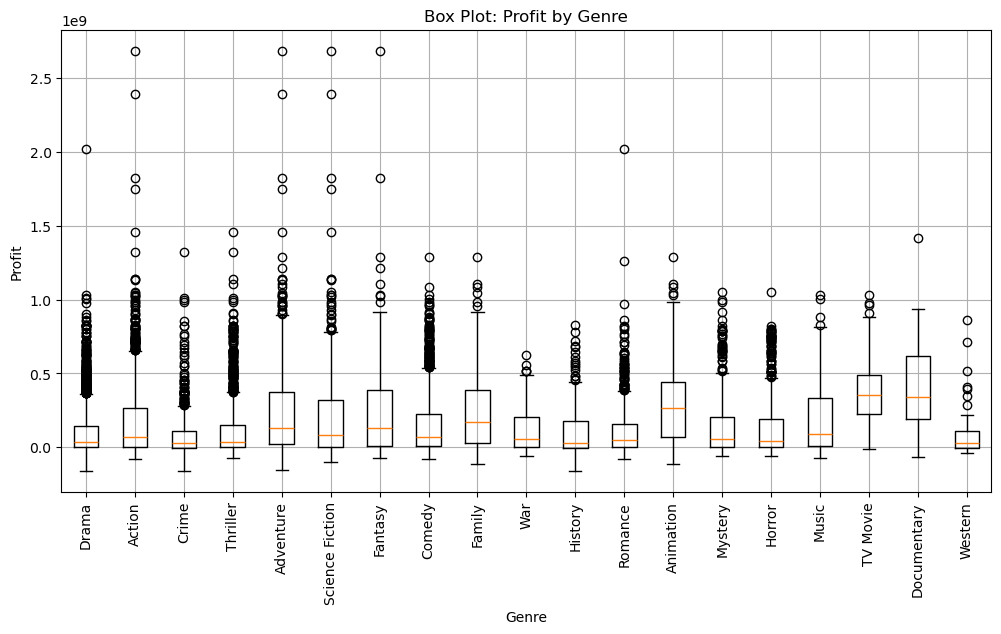

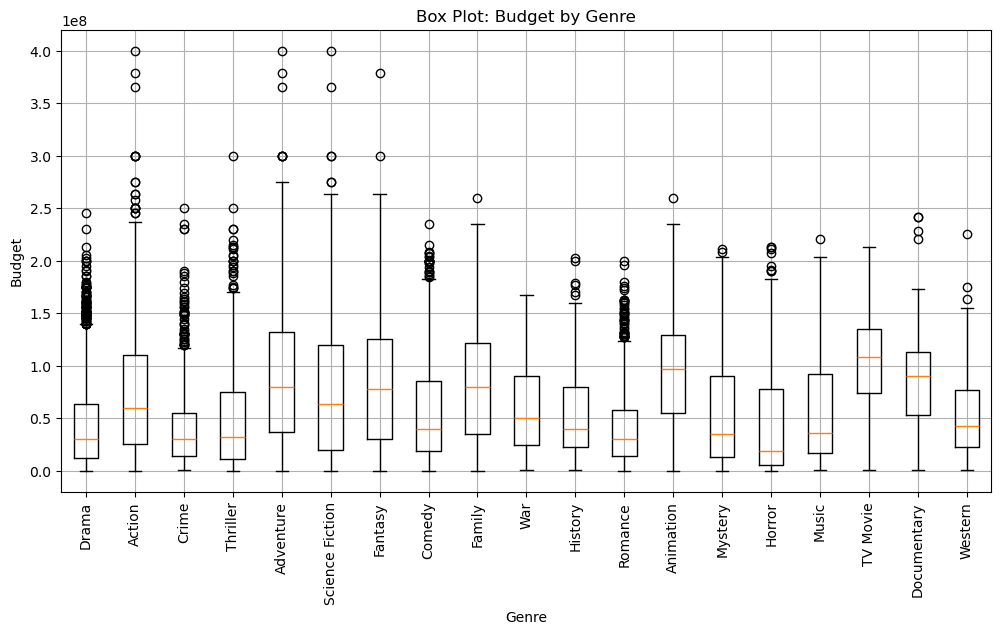

In [6]:
# Set the figure size
plt.figure(figsize=(12, 6))

# Box plot for Revenue by Genre
plt.boxplot([df_genre[df_genre['Genre'] == genre]['Revenue'] for genre in df_genre['Genre'].unique()], labels=df_genre['Genre'].unique())
plt.xlabel('Genre')
plt.ylabel('Revenue')
plt.title('Box Plot: Revenue by Genre')
plt.xticks(rotation=90)  
plt.grid(True)
plt.show()

# Set the figure size
plt.figure(figsize=(12, 6))

# Box plot for Profit by Genre
plt.boxplot([df_genre[df_genre['Genre'] == genre]['Profit'] for genre in df_genre['Genre'].unique()], labels=df_genre['Genre'].unique())
plt.xlabel('Genre')
plt.ylabel('Profit')
plt.title('Box Plot: Profit by Genre')
plt.xticks(rotation=90)  
plt.grid(True)
plt.show()

# Set the figure size
plt.figure(figsize=(12, 6))

# Box plot for Budget by Genre
plt.boxplot([df_genre[df_genre['Genre'] == genre]['Budget'] for genre in df_genre['Genre'].unique()], labels=df_genre['Genre'].unique())
plt.xlabel('Genre')
plt.ylabel('Budget')
plt.title('Box Plot: Budget by Genre')
plt.xticks(rotation=90)  
plt.grid(True)
plt.show()

# Calculate statistics and outliers for revenue by genre

In [7]:
# Initialize dictionary to store outliers, mean, mode, median, and outlier count for each genre
genre_info = {}
genres = df_genre['Genre'].unique()
# Loop through each genre
for genre in genres:
    # Filter DataFrame for the current genre
    genre_data = df_genre[df_genre['Genre'] == genre]
    
    # Calculate quartiles and IQR for revenue
    quartiles = genre_data['Revenue'].quantile([0.25, 0.5, 0.75])
    lower_q = quartiles[0.25]
    upper_q = quartiles[0.75]
    IQR = upper_q - lower_q
    
    # Calculate lower and upper bounds for outliers
    lower_bound = lower_q - 1.5 * IQR
    upper_bound = upper_q + 1.5 * IQR
    
    # Identify outliers for the current genre
    outliers = genre_data[(genre_data['Revenue'] < lower_bound) | (genre_data['Revenue'] > upper_bound)]
    
    # Store outliers and outlier count for the current genre in the dictionary
    genre_info[genre] = {
        'outliers': outliers['Revenue'],
        'outlier_count': len(outliers),  
        'mean': genre_data['Revenue'].mean(),
        'mode': genre_data['Revenue'].mode(),
        'median': genre_data['Revenue'].median(),
    }

    # Print information for the current genre
    print(f"\nGenre: {genre}")
    print(f"Lower Quartile: {lower_q}")
    print(f"Upper Quartile: {upper_q}")
    print(f"IQR: {IQR}")
    print(f"Lower Bound: {lower_bound}")
    print(f"Upper Bound: {upper_bound}")
    print(f"Outliers: {outliers['Revenue']}")
    print(f"Number of Outliers: {len(outliers)}")  # Print count of outliers
    print(f"Mean: {genre_info[genre]['mean']}")
    print(f"Mode: {genre_info[genre]['mode']}")
    print(f"Median: {genre_info[genre]['median']}")

# Print information for each genre
for genre, info in genre_info.items():
    print(f"\nGenre: {genre}")
    print(f"Outliers: {info['outliers']}")
    print(f"Number of Outliers: {info['outlier_count']}")
    print(f"Mean: {info['mean']}")
    print(f"Mode: {info['mode']}")
    print(f"Median: {info['median']}")


Genre: Drama
Lower Quartile: 16513173.0
Upper Quartile: 208182454.0
IQR: 191669281.0
Lower Bound: -270990748.5
Upper Bound: 495686375.5
Outliers: 0        6.223136e+08
31       6.278511e+08
52       6.480827e+08
76       6.835455e+08
84       5.707950e+08
             ...     
13407    1.052163e+09
13422    5.327746e+08
13614    8.846484e+08
13644    6.278157e+08
13764    4.989683e+08
Name: Revenue, Length: 166, dtype: float64
Number of Outliers: 166
Mean: 154862405.4130554
Mode: 0    211802400.4
1    583921229.0
Name: Revenue, dtype: float64
Median: 61603136.0

Genre: Action
Lower Quartile: 33463479.5
Upper Quartile: 365347948.0
IQR: 331884468.5
Lower Bound: -464363223.25
Upper Bound: 863174650.75
Outliers: 9        2.923706e+09
23       2.048360e+09
70       2.794732e+09
93       9.610000e+08
117      1.045714e+09
140      1.395317e+09
145      1.065660e+09
185      9.403230e+08
237      1.236704e+09
267      8.782713e+08
301      1.514553e+09
320      8.912168e+08
329      1.151900

# Calculate statistics without presence of outliers for revenue by genre

In [8]:
# Define unique genres
genres = df_genre['Genre'].unique()

# Initialize dictionary to store mean, mode, and median for each genre
genre_stats = {}

# Loop through each genre
for genre in genres:
    # Filter DataFrame for the current genre
    genre_data = df_genre[df_genre['Genre'] == genre]
    
    # Calculate quartiles and IQR for revenue
    quartiles = genre_data['Revenue'].quantile([0.25, 0.5, 0.75])
    lower_q = quartiles[0.25]
    upper_q = quartiles[0.75]
    IQR = upper_q - lower_q
    
    # Calculate lower and upper bounds for outliers
    lower_bound = lower_q - 1.5 * IQR
    upper_bound = upper_q + 1.5 * IQR
    
    # Filter out outliers for the current genre
    genre_data_filtered = genre_data[(genre_data['Revenue'] >= lower_bound) & (genre_data['Revenue'] <= upper_bound)]
    
    # Calculate mean, mode, and median for the filtered data
    mean = genre_data_filtered['Revenue'].mean()
    mode = genre_data_filtered['Revenue'].mode()
    median = genre_data_filtered['Revenue'].median()
    
    # Store stats for the current genre in the dictionary
    genre_stats[genre] = {
        'mean': mean,
        'mode': mode,
        'median': median
    }

    # Print information for the current genre
    print(f"\nGenre: {genre}")
    print(f"Mean (without outliers): {mean}")
    print(f"Mode (without outliers): {mode}")
    print(f"Median (without outliers): {median}")

# Print information for each genre
for genre, stats in genre_stats.items():
    print(f"\nGenre: {genre}")
    print(f"Mean (without outliers): {stats['mean']}")
    print(f"Mode (without outliers): {stats['mode']}")
    print(f"Median (without outliers): {stats['median']}")


Genre: Drama
Mean (without outliers): 102206271.21846712
Mode (without outliers): 0    211802400.4
Name: Revenue, dtype: float64
Median (without outliers): 50363790.0

Genre: Action
Mean (without outliers): 208504159.25010896
Mode (without outliers): 0    211802400.4
Name: Revenue, dtype: float64
Median (without outliers): 125168734.0

Genre: Crime
Mean (without outliers): 81281544.08691588
Mode (without outliers): 0    103880027.0
Name: Revenue, dtype: float64
Median (without outliers): 48904871.9

Genre: Thriller
Mean (without outliers): 112303222.92299627
Mode (without outliers): 0    38139010.0
Name: Revenue, dtype: float64
Median (without outliers): 56890649.0

Genre: Adventure
Mean (without outliers): 300039377.0569709
Mode (without outliers): 0      1240261.6
1    262387752.0
Name: Revenue, dtype: float64
Median (without outliers): 210286400.2

Genre: Science Fiction
Mean (without outliers): 246839286.1318777
Mode (without outliers): 0      2360000.0
1    142531552.0
2    33313

# Visual 1: Overview of Genres (Bar chart, pie chart) by sum/average(decide later) revenue & Genre by movie count

In [9]:
# Group the DataFrame by genre and calculate total revenue for each genre
genre_revenue = df_genre.groupby('Genre').agg({'Revenue': 'sum', 'Name': 'count'})
genre_revenue['Average_Revenue'] = genre_revenue['Revenue'] / genre_revenue['Name']
genre_revenue.reset_index(inplace=True)

# Three top Genres:
genre_revenue_sorted = genre_revenue.sort_values ("Revenue",ascending = False)
genre_revenue_sorted.head(5)

,Genre,Revenue,Name,Average_Revenue
0,Action,3.546686e+11,1436,2.469837e+08
3,Comedy,3.429143e+11,1666,2.058309e+08
1,Adventure,3.271453e+11,1015,3.223107e+08
6,Drama,2.823142e+11,1823,1.548624e+08
7,Family,2.805633e+11,886,3.166628e+08


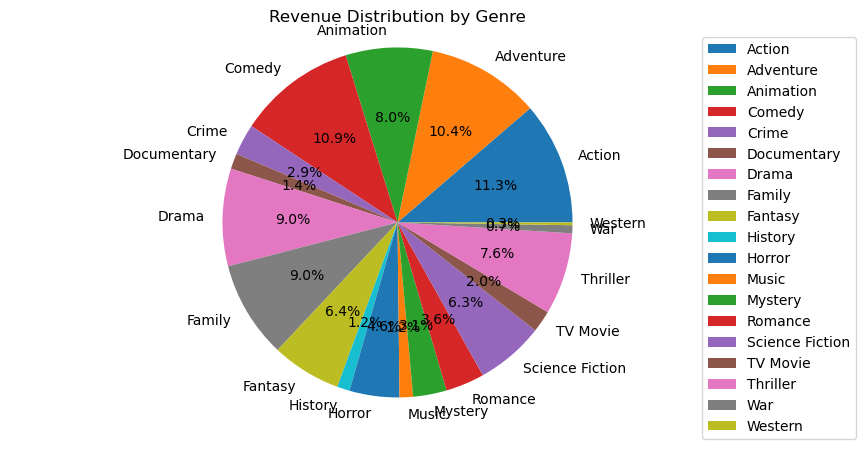

In [10]:
# Plotting the pie chart
plt.figure(figsize=(10, 5))
plt.pie(genre_revenue["Revenue"], labels=genre_revenue['Genre'], autopct='%1.1f%%')
plt.legend(loc="upper right", bbox_to_anchor=(1.1, 1))
plt.title('Revenue Distribution by Genre')
plt.axis('equal')
plt.show()

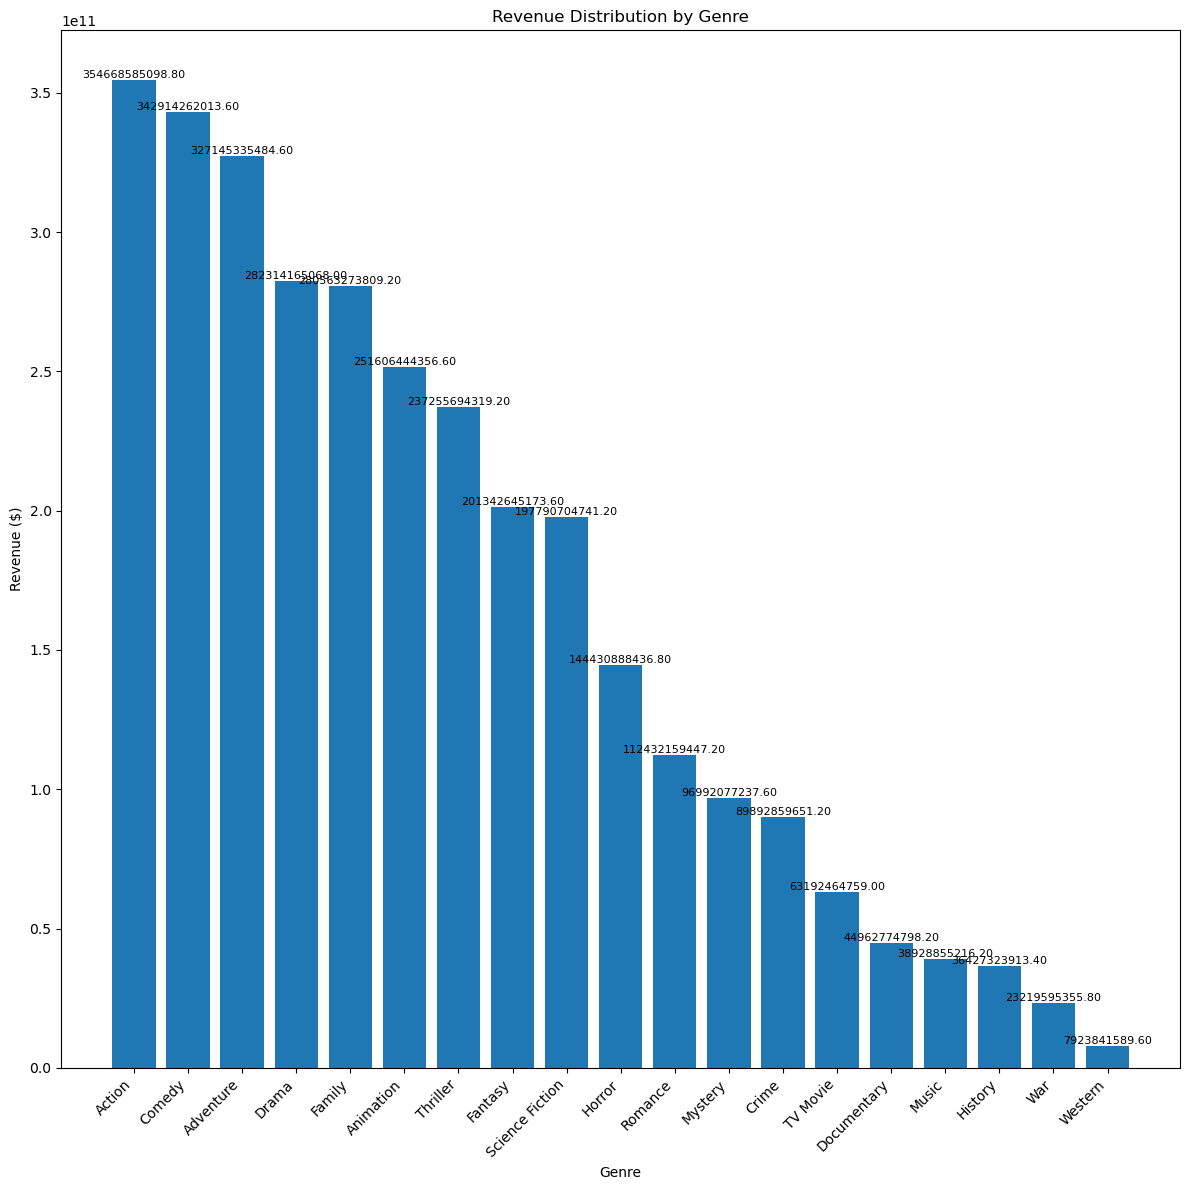

In [48]:
# Plotting the bar chart
plt.figure(figsize=(12, 12))
bars = plt.bar(genre_revenue_sorted['Genre'], genre_revenue_sorted["Revenue"], align="center")
plt.xticks(rotation=45, ha="right")
plt.xlabel('Genre')
plt.ylabel("Revenue ($)")
plt.title('Revenue Distribution by Genre')

#Annotate each bar with its value
plt.bar_label(bars, fmt='%.2f', label_type='edge', fontsize=8)
plt.tight_layout()

# Show the plot
plt.show()


# Visual 2: Breakdown by three decades

In [12]:
df_genre.head(5)

,Name,Genre,Revenue,Profit,Budget,Year
0,the passion of the christ,Drama,622313635.0,597313635.0,25000000.0,2004
1,john wick: chapter 2,Action,171539887.0,131539887.0,40000000.0,2017
2,john wick: chapter 2,Crime,171539887.0,131539887.0,40000000.0,2017
3,john wick: chapter 2,Thriller,171539887.0,131539887.0,40000000.0,2017
4,john wick: chapter 3 - parabellum,Action,326709727.0,271709727.0,55000000.0,2019


In [39]:
# Filter for selected Genres
df_genre_copy = df_genre.copy()
df_genre_copy["Genre"] = df_genre_copy["Genre"].str.strip().str.lower()
selected_genres = ["action", "comedy", "adventure"]
df_genre_filtered = df_genre_copy[df_genre_copy["Genre"].isin(selected_genres)]
df_genre_filtered

# Bin the "Year" column into decades
# Right=True to include the right endpoint of each bin
df_genre_filtered_copy = df_genre_filtered.copy()
Year_bins = [1990, 2000, 2010, 2020]
labels = ["1990-1999", "2000-2009", "2010-2019"]
df_genre_filtered_copy["Genre"]=df_genre_filtered_copy["Genre"].str.capitalize()
df_genre_filtered_copy ["Decade"] = pd.cut(df_genre_filtered_copy["Year"], Year_bins,labels = labels)
df_genre_profit = df_genre_filtered_copy.groupby(["Genre","Decade"],observed=False)["Profit"].sum().reset_index()
df_genre_profit.head(5)

,Genre,Decade,Profit
0,Action,1990-1999,2.288694e+10
1,Action,2000-2009,6.640723e+10
2,Action,2010-2019,1.594338e+11
3,Adventure,1990-1999,2.092248e+10
4,Adventure,2000-2009,7.635522e+10


<Figure size 1200x600 with 0 Axes>

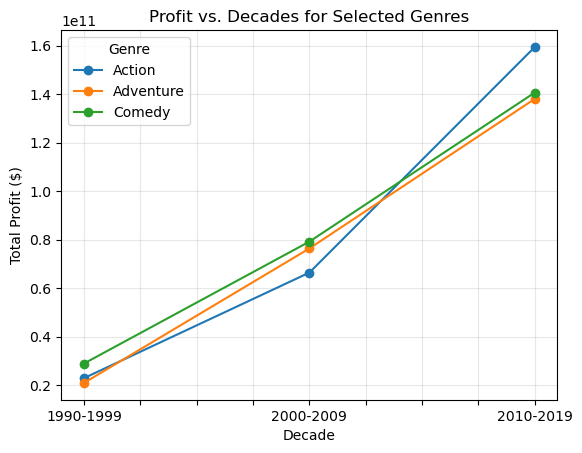

In [45]:
# Plot the profit for each genre over decades
# plt.figure(figsize=(12, 6))
# df_genre_pivot.plot(kind='line', marker='o')

# plt.title('Profit vs. Decades for Selected Genres')
# plt.xlabel('Decade')
# plt.ylabel('Total Profit ($)')
# plt.grid(True)
# plt.show()


# Pivot the DataFrame to have genres as columns
df_genre_pivot = df_genre_profit.pivot(index='Decade', columns='Genre', values='Profit')

# Plot the profit for each genre over decades
plt.figure(figsize=(12, 6))
df_genre_pivot.plot(kind='line', marker='o')

plt.title('Profit vs. Decades for Selected Genres')
plt.xlabel('Decade')
plt.ylabel('Total Profit ($)')
plt.grid(True, alpha = 0.3)
plt.show()





<Figure size 1200x600 with 0 Axes>

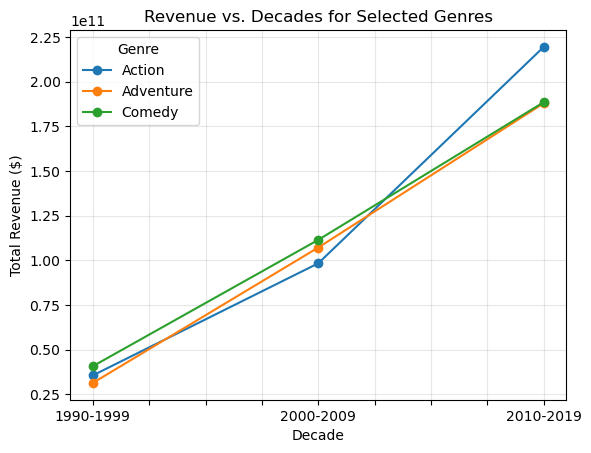

In [44]:
df_genre_revenue = df_genre_filtered_copy.groupby(["Genre","Decade"],observed=False)["Revenue"].sum().reset_index()
df_genre_revenue.head(5)

df_genre_pivot = df_genre_revenue.pivot(index='Decade', columns='Genre', values='Revenue')

# Plot the profit for each genre over decades
plt.figure(figsize=(12, 6))
df_genre_pivot.plot(kind='line', marker='o')

plt.title('Revenue vs. Decades for Selected Genres')
plt.xlabel('Decade')
plt.ylabel('Total Revenue ($)')
plt.grid(True, alpha = 0.3)
plt.show()

<Figure size 1200x600 with 0 Axes>

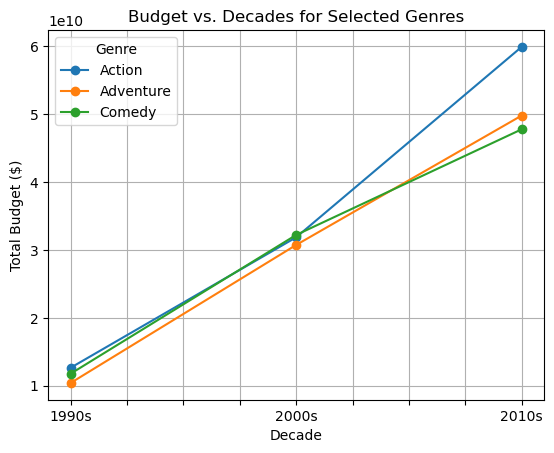

In [38]:
df_genre_revenue = df_genre_filtered_copy.groupby(["Genre","Decade"],observed=False)["Budget"].sum().reset_index()
df_genre_revenue.head(5)

df_genre_pivot = df_genre_revenue.pivot(index='Decade', columns='Genre', values='Budget')

# Plot the profit for each genre over decades
plt.figure(figsize=(12, 6))
df_genre_pivot.plot(kind='line', marker='o')

plt.title('Budget vs. Decades for Selected Genres')
plt.xlabel('Decade')
plt.ylabel('Total Budget ($)')
plt.grid(True)
plt.show()

# Gross Domestic Income (GDI) vs. Box Office Revenue